In [208]:
# Import packages
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts
from matplotlib import pyplot as plt
import statistics
import math
from sklearn.preprocessing import StandardScaler
from numpy.linalg import eig
from scipy import linalg as la
from skrmt.ensemble import GaussianEnsemble, marchenko_pastur_law
import scipy

In [53]:
fut_list = ['ES=F','CL=F','ZN=F','^VIX','DX-Y.NYB']
data= yf.download(fut_list, start="2017-01-01", end="2023-02-17")['Close']

[*********************100%***********************]  5 of 5 completed


In [54]:
x=pd.DataFrame(data=data)
log = np.log(x/x.shift())
log_corr = pd.DataFrame(data=log.corr())
log_corr

C:\Users\Chetan\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


,CL=F,DX-Y.NYB,ES=F,ZN=F,^VIX
CL=F,1.00000,-0.047650,0.225740,-0.090000,-0.188790
DX-Y.NYB,-0.04765,1.000000,-0.171236,-0.281333,0.095015
ES=F,0.22574,-0.171236,1.000000,-0.151765,-0.701008
ZN=F,-0.09000,-0.281333,-0.151765,1.000000,0.150477
^VIX,-0.18879,0.095015,-0.701008,0.150477,1.000000


In [56]:
ee,ev=la.eig(log_corr)

In [57]:
ee

array([1.88611818+0.j, 1.28292986+0.j, 0.89357374+0.j, 0.29269377+0.j,
       0.64468446+0.j])

In [58]:
ev

array([[ 0.32996101, -0.03817905, -0.9394804 , -0.03577457, -0.0759266 ],
       [-0.14604201, -0.72125065,  0.02838429,  0.09798468, -0.66937476],
       [ 0.65048945,  0.06489395,  0.20622786,  0.72154012, -0.09747915],
       [-0.20649442,  0.68847634, -0.04622443,  0.04392184, -0.69231103],
       [-0.63562646, -0.01135635, -0.26814973,  0.68305923,  0.23953254]])

In [59]:
ev2 = np.diag(ev.sum(axis=1))
print(ev2)

[[-0.75939962  0.          0.          0.          0.        ]
 [ 0.         -1.41029844  0.          0.          0.        ]
 [ 0.          0.          1.54567223  0.          0.        ]
 [ 0.          0.          0.         -0.2126317   0.        ]
 [ 0.          0.          0.          0.          0.00745923]]


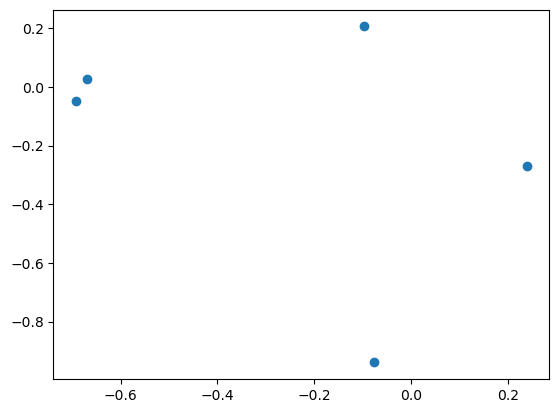

In [93]:
plt.scatter(ev[:, 4], ev[:, 2])

In [99]:
def create_combined_array(n, func):
    combined_array = []
    for i in range(n):
        new_array = func(i)  
        flattened_array = np.ndarray.flatten(new_array)  
        combined_array += flattened_array.tolist()  
    return combined_array

In [95]:
def create_correlation_matrices(data, window_size=30, num_loops=None):

    if isinstance(data, pd.DataFrame):
        data = data.to_numpy()
    
    n_samples = data.shape[0]
    if num_loops is None:
        num_loops = int(np.ceil(n_samples / window_size))
    else:
        num_loops = min(num_loops, int(np.ceil(n_samples / window_size)))
    
    corr_matrices = []
    for i in range(num_loops):
        start_idx = i * window_size
        end_idx = min(start_idx + window_size, n_samples)
        subset = data[start_idx:end_idx, :]
        corr_matrix = np.corrcoef(subset.T)
        corr_matrices.append(corr_matrix)
    
    return corr_matrices

In [198]:
corr_matrices = create_correlation_matrices(log, window_size=30)
x = np.nan_to_num(corr_matrices, posinf = 0)

In [199]:
def get_eigenvalues_eigenvectors(corr_matrices):
    eigenvalues = []
    eigenvectors = []
    
    for corr_matrix in corr_matrices:
        eig_vals, eig_vecs = np.linalg.eig(corr_matrix)
        eigenvalues.append(eig_vals)
        eigenvectors.append(eig_vecs)
    
    return eigenvalues, eigenvectors

In [200]:
values,vectors = get_eigenvalues_eigenvectors(x)

In [151]:
def vector_plot(x):
    for i, eig_vecs in enumerate(x):
        x = eig_vecs[:, 2]
        y = eig_vecs[:, 4]
        plt.scatter(x, y, c='blue')
    
    plt.xlabel("ES=F")
    plt.ylabel("VIX")
    plt.show()

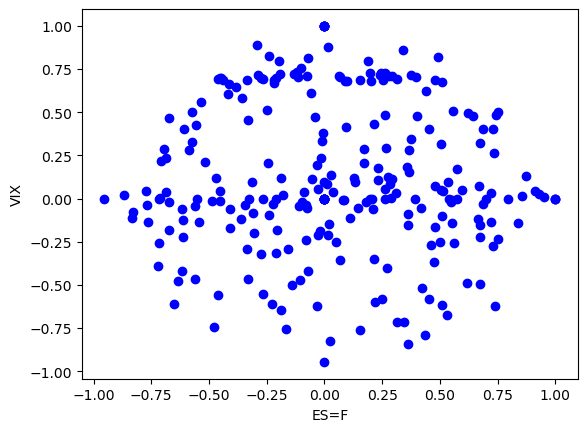

In [201]:
vector_plot(np.real(vectors))

In [202]:
def plot_eigenvalue(eigenvalues,time_interval):
    eigenvalue_2 = [eig_vals[2] for eig_vals in eigenvalues]
    time = [i*time_interval for i in range(len(eigenvalues))]
    
    plt.plot(time, eigenvalue_2)
    plt.xlabel("time")
    plt.ylabel("ES=F")
    plt.show()

In [203]:
def get_estimated_eigenvalues(corr_matrices):
    estimated_eigenvalues = []
    for corr_matrix in corr_matrices:
        n = corr_matrix.shape[0]
        sample_covariance = (n - 1) / n * np.cov(corr_matrix, rowvar=False, bias=True)
        eig_vals, _ = np.linalg.eig(sample_covariance)
        eig_vals_sorted = np.sort(eig_vals)[::-1]
        estimated_eigenvalues.append(eig_vals_sorted)
    return estimated_eigenvalues


def calc_eigenvalue_diffs(real_eigenvalues, estimated_eigenvalues):
    eigenvalue_diffs = []
    for i in range(len(real_eigenvalues)):
        diff = real_eigenvalues[i] - estimated_eigenvalues[i]
        eigenvalue_diffs.append(diff)
    return eigenvalue_diffs

In [204]:
estimated_eigenvalues = get_estimated_eigenvalues(x)

# Calculate the eigenvalue differences between the real and estimated eigenvalues for each matrix
eigenvalue_diffs = calc_eigenvalue_diffs(values, estimated_eigenvalues)

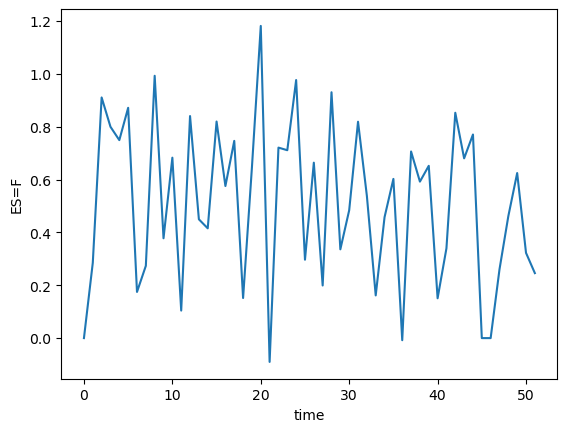

In [205]:
plot_eigenvalue(np.real(eigenvalue_diffs),1)

In [206]:
def plot_eigenvalue_boxplot(eigenvalues):
    # Extract all 5 eigenvalues for each matrix into a 2D array
    eigenvalues_all = np.array(eigenvalues)[:, :5]
    
    # Create a boxplot of all 5 eigenvalues
    plt.boxplot(eigenvalues_all, labels=["DXY", "CL=F", "ES=F",
                                          "ZN=F", "VIX"])
    plt.xlabel("Asset")
    plt.show()

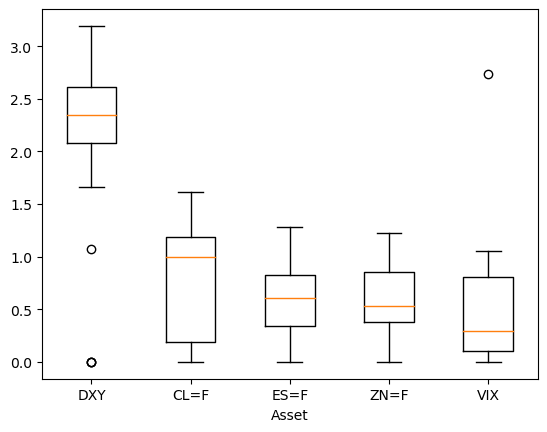

In [207]:
plot_eigenvalue_boxplot(np.real(values))